# Libraries & functions

In [1]:
from Galutils import *

# Loading data & Language model

This is an iterative process, in which the results help to refine and select the corpus, which helps to train a better model, which helps to better analyze the data.

In [2]:
model_path=Path.cwd().parent/'Model'
data_path=Path.cwd().parent/'dataset'

In [3]:
nlp=spacy.load(model_path/'gl_lg')          

/home/luis/.local/lib/python3.10/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'pt_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
%%time
all_sents=(data_path/'wiki_sents_gal.txt').read_text(encoding='utf8').split('\n')
len(all_sents)

CPU times: user 1.17 s, sys: 1.49 s, total: 2.65 s
Wall time: 4.38 s


2281265

If you have the pickle file *wiki_gal_tokens.pkl* generated in the *Exploit_Wiki_get_sentences* notebook then you can save some time. Pease chek that lenght of _tokens_ and _sents_ are the same and the language model does not change for one to another 

In [5]:
%%time
all_toks=pickle_var(data_path/'wiki_gal_tokens.pkl')
len(all_toks)

CPU times: user 16.4 s, sys: 3.05 s, total: 19.4 s
Wall time: 20 s


2281265

If you don't have the file run the following cells

In [ ]:
def thread(sents):
    return [[(item.text,item.pos_,item.lemma_) for item in nlp(sent)] for sent in sents]

In [ ]:
%%time
all_toks=[]
for chunk in vectorice(all_sents,thread,max_workers=10):
    all_toks+=chunk
len(all_toks)

# Processing corpus


In [6]:
%%time
bow,lemma,tfidf,propn=process_corpus(all_toks)

CPU times: user 59 s, sys: 71.3 ms, total: 59.1 s
Wall time: 59.1 s


In [7]:
corpus=corpuscle(model_path/'gl_lg',bow,lemma,tfidf,propn)

pickle_var(model_path/'wiki_gal_corpuscle.pkl',corpus)

print(f'Unique tokens: {len(bow)}\nUnique lemmas:{len(lemma)}\nUnique proper nouns: {len(propn)}')

Unique tokens: 389738
Unique lemmas:92360
Unique proper nouns: 460809


# Sentences dataframe

`dfval` is a dataframe for keep relevant values about corpus sentences, 
* value: Sum of tfidf values of tokens in sentence
* ntoks: numbre of alphabetical toks in sentence
* mean: mean value, $\cfrac{value}{ntoks}$
* weight: weighted values $\left ( 1+\cfrac{k}{ntoks} \right )$, where k is a parameter set to 300
* %na: proportion of (PROPN,SYM,PUNCT,NUM,X) in sentence

## Valuating sentences

In [8]:
import stopwordsiso as stopwords
stopw=stopwords.stopwords('gl')

In [9]:
def thread(sents):
    res=[]
    for sent in sents:
        tok,pos,lemma=transpose(sent)
        val=sum([corpus.tfidf[lm] for l in lemma if (lm:=l.lower()) in corpus.tfidf.keys() and not lm in stopw])
        dp=Counter(pos)
        na=sum([val for key,val in dp.items() if key in ['PROPN','X','SYM','PUNCT','NUM']])
        res.append((val,len(sent),na/sum(dp.values())))    
    return res

In [10]:
%%time
res=thread(all_toks)

CPU times: user 24.9 s, sys: 63.2 ms, total: 24.9 s
Wall time: 24.9 s


In [11]:
dfval=pd.DataFrame(res,columns=['value','ntoks','%na'])
dfval['mean']=dfval['value']/dfval['ntoks']
dfval['weight']=dfval['value']+300*dfval['mean']
dfval.describe()

,value,ntoks,%na,mean,weight
count,2.281265e+06,2.281265e+06,2.281265e+06,2.281265e+06,2.281265e+06
mean,8.406319e-03,2.524111e+01,2.441761e-01,3.320679e-04,1.080267e-01
std,6.472233e-03,1.408683e+01,1.369304e-01,1.970286e-04,6.327832e-02
min,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.674735e-03,1.500000e+01,1.428571e-01,1.914487e-04,6.213773e-02
50%,6.865382e-03,2.200000e+01,2.222222e-01,2.964234e-04,9.704988e-02
75%,1.151528e-02,3.200000e+01,3.214286e-01,4.349508e-04,1.428732e-01
max,2.765955e-01,9.650000e+02,9.823009e-01,2.893250e-03,8.795480e-01


In [ ]:
dfval.sort_values('weight')

In [ ]:
all_toks[1543561]

In [ ]:
cl='weight'
dfval.boxplot(cl)


In [ ]:
dfval.plot.scatter('ntoks','weight')
plt.grid()

In [ ]:
from random import sample
indx=dfval[(dfval['weight']<3.7e-3) & (dfval['weight']>=0)].index#(dfval['ntoks']/4640+1/1160))].index# 
print(len(indx))
for i in sample(sorted(indx),min(20,len(indx))):
    print(all_sents[i])
    print()


### Filter values

To keep only valuable sentences to train a language model, so sentences with lists, with many symbols, etc. are filtered.

Iterative process:

1. drop _%na_>= 0.5
1. drop _ntoks_ >120
1. drop _weight_ under the line _ntoks_*/4640+1/1160
1. drop _weight_ <3.7e-3

In [ ]:
for i in sorted(indx,reverse=True):
    all_sents.pop(i)
    all_toks.pop(i)

In [13]:
indx=list(dfval[dfval['%na']>=0.5].index)
indx+=list(dfval[dfval['ntoks']>120].index)
indx+=list(dfval[dfval['weight']<3.7e-3].index)
indx+=list(dfval[dfval['weight']<dfval['ntoks']/4640+1/1160].index)
indx=list(set(indx))
indx.sort(reverse=True)
for i in indx:
    all_sents.pop(i)
    all_toks.pop(i)

In [14]:
%%time
res=thread(all_toks)
dfval=pd.DataFrame(res,columns=['value','ntoks','%na'])
dfval['mean']=dfval['value']/dfval['ntoks']
dfval['weight']=dfval['value']+300*dfval['mean']

CPU times: user 24.6 s, sys: 76.1 ms, total: 24.7 s
Wall time: 24.6 s


In [15]:
dfval.describe()

,value,ntoks,%na,mean,weight
count,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06
mean,8.668317e-03,2.546123e+01,2.224973e-01,3.406071e-04,1.108504e-01
std,6.424979e-03,1.353517e+01,1.083949e-01,1.937244e-04,6.225587e-02
min,4.942069e-05,4.000000e+00,0.000000e+00,1.184321e-05,3.700874e-03
25%,3.946951e-03,1.600000e+01,1.346154e-01,2.008695e-04,6.525061e-02
50%,7.172587e-03,2.300000e+01,2.105263e-01,3.050567e-04,9.994724e-02
75%,1.180798e-02,3.200000e+01,3.000000e-01,4.430101e-04,1.454267e-01
max,9.432141e-02,1.200000e+02,4.956522e-01,2.893250e-03,8.795480e-01


In [16]:
dfval.corr()

,value,ntoks,%na,mean,weight
value,1.000000,0.710412,-0.109981,0.611792,0.674325
ntoks,0.710412,1.000000,0.001934,-0.001510,0.071907
%na,-0.109981,0.001934,1.000000,-0.148539,-0.150015
mean,0.611792,-0.001510,-0.148539,1.000000,0.996662
weight,0.674325,0.071907,-0.150015,0.996662,1.000000


# POS/lemma associations

## Markov transition matrix

In [17]:
postag=['ADJ',
     'ADP',
     'ADV',
     'AUX',
     'CCONJ',
     'CONJ',
     'DET',
     'NOUN',
     'NUM',
     'PRON',
     'PROPN',
     'PUNCT',
     'SCONJ',
     'SYM',
     'VERB',
     'X']
indexpos={key:val+1 for val,key in enumerate(postag)}



In [18]:
def transition_pos(all_s):
    ptmc=np.zeros([len(postag)+1,len(postag)+1])
    for s in all_s:
        p=[item[1] for item in s]

        ptmc[0,indexpos[p[0]]]+=1
        for i in range(1,len(p)):
            ptmc[indexpos[p[i-1]],indexpos[p[i]]]+=1
        ptmc[indexpos[p[-1]],0]+=1
    return ptmc

In [19]:
%%time
ptmc=transition_pos(all_toks)

CPU times: user 24.8 s, sys: 3.56 ms, total: 24.8 s
Wall time: 24.7 s


In [20]:
ptmc=ptmc.T/ptmc.sum(axis=0)
dfptmc=pd.DataFrame(ptmc.T,columns=['end']+postag,index=['start']+postag)
dfptmc

,end,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X
start,0.000000,0.005671,0.202515,0.094971,0.014863,0.001720,0.011341,0.325813,0.022928,0.007694,0.051692,0.114265,0.001976,0.001146,0.000046,0.143358,0.000000e+00
ADJ,0.001169,0.042054,0.246548,0.023017,0.004972,0.068318,0.003203,0.017910,0.190169,0.002898,0.011268,0.027717,0.271942,0.015320,0.000043,0.073451,0.000000e+00
ADP,0.000582,0.037434,0.006335,0.015007,0.001339,0.000462,0.000278,0.049250,0.509983,0.089633,0.057166,0.169465,0.003633,0.012816,0.000017,0.046600,0.000000e+00
ADV,0.000231,0.113940,0.187811,0.055146,0.019357,0.005275,0.004126,0.101463,0.112422,0.009006,0.056774,0.027445,0.061007,0.045808,0.000028,0.200158,9.904712e-07
AUX,0.000038,0.016904,0.002164,0.002282,0.002772,0.000011,0.000027,0.000373,0.007048,0.000029,0.000751,0.001922,0.000027,0.000000,0.000000,0.965653,0.000000e+00
CCONJ,0.000146,0.058146,0.118027,0.063890,0.012395,0.000195,0.001470,0.185951,0.177319,0.046290,0.033038,0.102181,0.013618,0.011290,0.000059,0.175979,4.851152e-06
CONJ,0.000156,0.052209,0.091365,0.087244,0.005261,0.001007,0.001335,0.167493,0.242551,0.007955,0.061725,0.036120,0.171864,0.011624,0.000047,0.062037,7.806340e-06
DET,0.000024,0.076622,0.019281,0.008261,0.000127,0.000593,0.000058,0.005288,0.692097,0.049610,0.083161,0.044751,0.001129,0.002479,0.000016,0.016502,0.000000e+00
NOUN,0.000898,0.187917,0.364815,0.028617,0.007451,0.047489,0.002603,0.015995,0.015612,0.013579,0.012762,0.033795,0.177995,0.010198,0.000050,0.080224,0.000000e+00
NUM,0.001716,0.013558,0.194305,0.012038,0.009434,0.060119,0.000730,0.022151,0.245504,0.020828,0.002794,0.053903,0.283955,0.002175,0.000107,0.076679,4.103199e-06


In [21]:
dfptmc.loc['VERB'].sort_values()

X        0.000000
SYM      0.000016
end      0.000667
CONJ     0.001633
AUX      0.002479
CCONJ    0.011625
PROPN    0.015326
NUM      0.016071
PRON     0.019067
SCONJ    0.025836
ADJ      0.040508
PUNCT    0.040604
VERB     0.062513
ADV      0.080122
NOUN     0.082453
DET      0.287066
ADP      0.314013
Name: VERB, dtype: float64

In [22]:
dfptmc.loc[:,'VERB'].sort_values()

DET      0.016502
ADP      0.046600
SYM      0.049955
CONJ     0.062037
VERB     0.062513
ADJ      0.073451
NUM      0.076679
NOUN     0.080224
PROPN    0.112005
PUNCT    0.117293
start    0.143358
CCONJ    0.175979
ADV      0.200158
SCONJ    0.284095
PRON     0.314352
X        0.576923
AUX      0.965653
Name: VERB, dtype: float64

In [23]:
pickle_var(data_path/'wiki_ptmc.pkl',dfptmc)



In [24]:
corpus.ptmc=dfptmc

## lemma/POS frequencies

In [25]:
%%time
lemma_pos={key:[0]*len(indexpos) for key in corpus.tfidf.keys()}
for sent in all_toks:
    for t,p,l in sent:
        if l in lemma_pos.keys():
            #indexpos-1: there is not start/end row/column
            lemma_pos[l][indexpos[p]-1]+=1

CPU times: user 15.3 s, sys: 3.92 ms, total: 15.3 s
Wall time: 15.3 s


In [26]:
posdata=pd.DataFrame(lemma_pos).T
posdata.columns=postag
for c in posdata.columns:
    if posdata[c].sum():
        continue
    posdata.drop(columns=c,inplace=True)

In [27]:
posdata['total']=posdata.sum(axis=1)
posdata=posdata[posdata['total']>0]
posdata.sort_values('total')

,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,total
mudan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
gobernamentais,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
separouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
laureada,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
vales,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ser,6,2,98,258009,0,0,0,6914,0,12,150,0,0,1,749175,0,1014367
do,90,1080750,1,0,0,0,2,1,1,7,10,0,0,0,9,0,1080871
e,0,0,0,0,1420458,18814,0,2,0,25,53,0,7,0,69,0,1439428
de,12,2797300,0,0,0,0,2,64,1,0,69,0,0,0,0,0,2797448


In [28]:
print(posdata.columns[posdata[postag].loc['acadar'].argmax()])
posdata.loc['acadar']

VERB


ADJ        20
ADP         0
ADV         0
AUX         0
CCONJ       0
CONJ        0
DET         0
NOUN        4
NUM         0
PRON        0
PROPN       0
PUNCT       0
SCONJ       0
SYM         0
VERB     9018
X           0
total    9042
Name: acadar, dtype: int64

In [29]:
for c in posdata.columns[:-1]:
    posdata[c]=posdata[c]/posdata['total']

In [30]:
posdata.describe()

,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,total
count,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,8.894400e+04,8.894400e+04
mean,0.213544,0.003330,0.019622,0.001040,0.000081,0.000247,0.000245,0.445798,0.001561,0.002687,0.026438,0.000089,0.000132,0.000138,0.285046,2.601409e-07,4.715415e+02
std,0.342281,0.043873,0.129548,0.018133,0.006096,0.010898,0.011739,0.435014,0.029484,0.036793,0.109883,0.005721,0.007499,0.005806,0.420837,5.519618e-05,1.842714e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.200000e+01
75%,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.985418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,4.400000e+01
max,1.000000,1.000000,1.000000,1.000000,0.986821,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.863074,1.000000,1.000000,1.574803e-02,3.558426e+06


In [31]:
corpus.pp=posdata
pickle_var(model_path/'wiki_gal_corpuscle.pkl',corpus)

In [32]:
tfidf=[]
for i in posdata.index:
    tfidf.append(corpus.tfidf[i])

posdata['tfidf']=tfidf

In [33]:
posdata.sort_values('total').tail(30)

,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,total,tfidf
primeiro,9.750843e-01,0.000047,2.073671e-03,0.000087,0.000000,0.000000,0.000000e+00,2.912637e-03,1.905086e-02,0.000000,0.000538,0.0,0.000000,0.000000e+00,2.057841e-04,0.000000e+00,126346,0.003772
co,2.121698e-03,0.995306,2.217803e-05,0.000000,0.000000,0.001678,0.000000e+00,5.470581e-04,0.000000e+00,0.000111,0.000192,0.0,0.000000,0.000000e+00,2.217803e-05,0.000000e+00,135269,0.003983
este,2.879583e-04,0.000043,7.198958e-06,0.000000,0.000000,0.000000,5.759166e-05,2.879583e-05,2.159687e-05,0.999554,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,138909,0.003946
dos,0.000000e+00,0.999931,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000069,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,145245,0.004140
estar,6.134677e-05,0.000048,0.000000e+00,0.483406,0.000000,0.000000,0.000000e+00,1.894933e-03,0.000000e+00,0.000014,0.000000,0.0,0.000000,6.816307e-06,5.145699e-01,0.000000e+00,146707,0.004172
ano,3.236937e-05,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,9.999158e-01,0.000000e+00,0.000000,0.000052,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,154467,0.004340
ter,0.000000e+00,0.000000,6.284368e-06,0.012204,0.000000,0.000000,0.000000e+00,2.010998e-04,0.000000e+00,0.000000,0.000019,0.0,0.000000,0.000000e+00,9.875695e-01,0.000000e+00,159125,0.004413
non,1.162547e-05,0.000000,9.995524e-01,0.000000,0.000000,0.000000,5.812737e-06,2.325095e-05,0.000000e+00,0.000407,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,172036,0.004628
polo,3.206174e-04,0.996502,5.725311e-06,0.000000,0.000000,0.000000,9.733029e-05,3.063041e-03,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000e+00,1.145062e-05,0.000000e+00,174663,0.004740
ou,0.000000e+00,0.000000,0.000000e+00,0.000000,0.936366,0.063634,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,178978,0.004923


In [34]:
pickle_var(data_path/'wiki_gal_posdata.pkl',posdata)

## The lemma-pos dataframe

array([-6.2785562 , -6.11595835, -5.80712043, -5.29783835, -1.90726299])

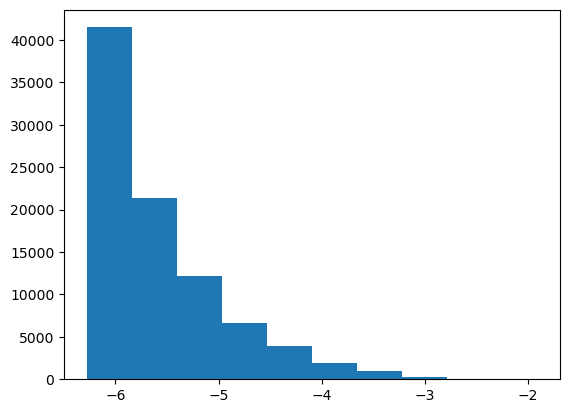

In [35]:
plt.hist(np.log10(posdata['tfidf']))
np.quantile(np.log10(posdata['tfidf']),[0.0,0.25,0.5,0.75,1])

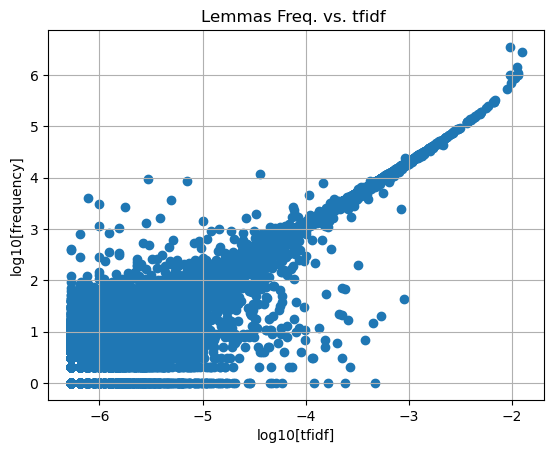

In [36]:
plt.scatter(np.log10(posdata.tfidf),np.log10(posdata.total))
plt.xlabel('log10[tfidf]')
plt.ylabel('log10[frequency]')
plt.title('Lemmas Freq. vs. tfidf ')
plt.grid()
           

array([[<AxesSubplot:title={'center':'SCONJ'}>]], dtype=object)

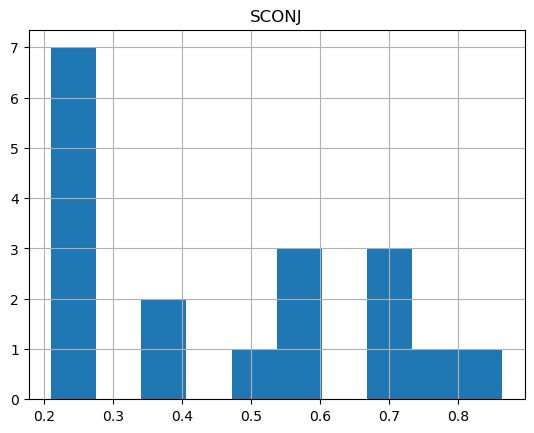

In [37]:
ps='SCONJ'
posdata[posdata[ps]>0.20].hist(ps,bins=10)


<AxesSubplot:>

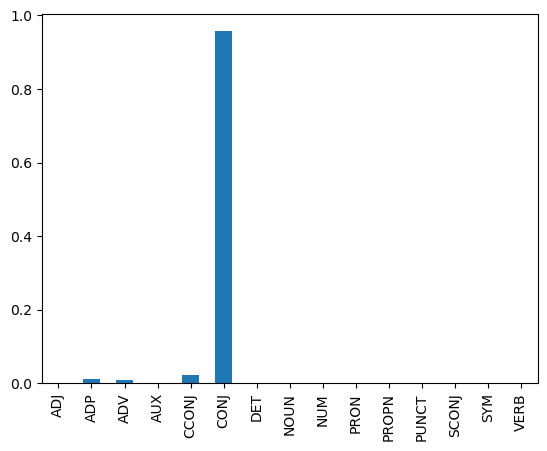

In [38]:
lm='porén'
posdata[posdata.columns[:-3]].loc[lm].plot.bar()

In [39]:
def thread(sents):
    rare_sents=[]

    for s in sents:
        temp=[]
        token,pos,lemma =transpose(s)
        temp=[posdata.loc[lm,pos[i]] for i,lm in enumerate(lemma) if lm in posdata.index]
            
        rare_sents.append((list_product(temp),min(temp) if temp else 0))
    return rare_sents

In [63]:
%%time
prob_sents=[]
for a in vectorice(all_toks,thread_function=thread,max_workers=10):
    prob_sents+=a
len(prob_sents)
prob_sents,min_sents=transpose(prob_sents)

CPU times: user 42.7 s, sys: 22.4 s, total: 1min 5s
Wall time: 5min 1s


In [64]:
dfval['prob']=prob_sents
dfval['min_prob']=min_sents
dfval.describe()

,value,ntoks,%na,mean,weight,prob,min_prob
count,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06
mean,8.668317e-03,2.546123e+01,2.224973e-01,3.406071e-04,1.108504e-01,2.721552e-01,4.124990e-01
std,6.424979e-03,1.353517e+01,1.083949e-01,1.937244e-04,6.225587e-02,2.975729e-01,3.039705e-01
min,4.942069e-05,4.000000e+00,0.000000e+00,1.184321e-05,3.700874e-03,0.000000e+00,0.000000e+00
25%,3.946951e-03,1.600000e+01,1.346154e-01,2.008695e-04,6.525061e-02,1.820315e-02,1.467903e-01
50%,7.172587e-03,2.300000e+01,2.105263e-01,3.050567e-04,9.994724e-02,1.475021e-01,3.193428e-01
75%,1.180798e-02,3.200000e+01,3.000000e-01,4.430101e-04,1.454267e-01,4.727325e-01,6.806512e-01
max,9.432141e-02,1.200000e+02,4.956522e-01,2.893250e-03,8.795480e-01,1.000000e+00,1.000000e+00


In [42]:
pickle_var(data_path/'wiki_gal_values.pkl',dfval)

In [43]:
cols=posdata.columns[:-2]

posdata['Sh']=-(np.log(posdata[cols])*posdata[cols]).fillna(0).sum(axis=1)

/home/luis/.local/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [44]:
posdata.describe()

,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,total,tfidf,Sh
count,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,88944.000000,8.894400e+04,8.894400e+04,8.894400e+04,88944.000000
mean,0.213544,0.003330,0.019622,0.001040,0.000081,0.000247,0.000245,0.445798,0.001561,0.002687,0.026438,0.000089,0.000132,0.000138,0.285046,2.601409e-07,4.715415e+02,1.906808e-05,0.255895
std,0.342281,0.043873,0.129548,0.018133,0.006096,0.010898,0.011739,0.435014,0.029484,0.036793,0.109883,0.005721,0.007499,0.005806,0.420837,5.519618e-05,1.842714e+04,1.674970e-04,0.327438
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,5.265551e-07,-0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,6.000000e+00,7.656700e-07,-0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.200000e+01,1.559120e-06,0.019625
75%,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.985418,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000e+00,4.400000e+01,5.036881e-06,0.522184
max,1.000000,1.000000,1.000000,1.000000,0.986821,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.863074,1.000000,1.000000,1.574803e-02,3.558426e+06,1.238047e-02,2.123155


In [45]:
posdata.sort_values('Sh').tail(30)

,ADJ,ADP,ADV,AUX,CCONJ,CONJ,DET,NOUN,NUM,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,total,tfidf,Sh
mailo,0.114286,0.001143,0.112000,0.000000,0.008000,0.001143,0.000000,0.163429,0.000000,0.201143,0.005714,0.000000,0.000000,0.000000,0.393143,0.0,875,6.923722e-05,1.562355
ve,0.061224,0.081633,0.000000,0.061224,0.000000,0.000000,0.000000,0.326531,0.000000,0.020408,0.081633,0.000000,0.000000,0.000000,0.367347,0.0,49,5.616643e-06,1.563858
ún,0.176471,0.294118,0.000000,0.000000,0.000000,0.000000,0.117647,0.235294,0.000000,0.000000,0.176471,0.000000,0.000000,0.000000,0.000000,0.0,17,1.777665e-06,1.564370
espero,0.000000,0.017544,0.000000,0.017544,0.000000,0.263158,0.000000,0.315789,0.000000,0.122807,0.035088,0.000000,0.000000,0.000000,0.228070,0.0,57,6.199661e-06,1.569377
disque,0.031532,0.045045,0.184685,0.009009,0.000000,0.013514,0.000000,0.432432,0.004505,0.040541,0.225225,0.000000,0.013514,0.000000,0.000000,0.0,222,1.814199e-05,1.571888
merca,0.330357,0.071429,0.062500,0.000000,0.000000,0.000000,0.000000,0.178571,0.000000,0.000000,0.303571,0.008929,0.000000,0.000000,0.044643,0.0,112,8.058787e-06,1.578151
sive,0.482759,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.137931,0.103448,0.068966,0.068966,0.000000,0.000000,0.000000,0.103448,0.0,29,4.095161e-06,1.579150
etc,0.198883,0.345251,0.001117,0.000000,0.153073,0.070391,0.000000,0.002235,0.000000,0.000000,0.216760,0.000000,0.004469,0.006704,0.001117,0.0,895,5.874821e-05,1.580442
moe,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.222222,0.000000,0.222222,0.222222,0.000000,0.000000,0.000000,0.222222,0.0,9,1.112261e-06,1.581094
iode,0.090909,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.363636,0.000000,0.000000,0.000000,0.090909,0.0,11,1.112261e-06,1.594167


count    88944.000000
mean         0.255895
std          0.327438
min         -0.000000
25%         -0.000000
50%          0.019625
75%          0.522184
max          2.123155
Name: Sh, dtype: float64

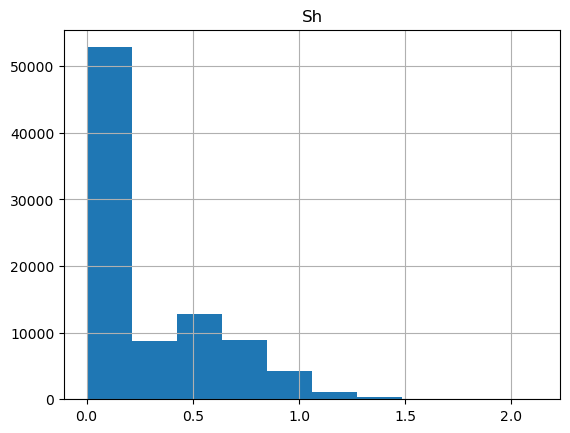

In [46]:
posdata.hist('Sh')
posdata['Sh'].describe()

<AxesSubplot:xlabel='tfidf', ylabel='Sh'>

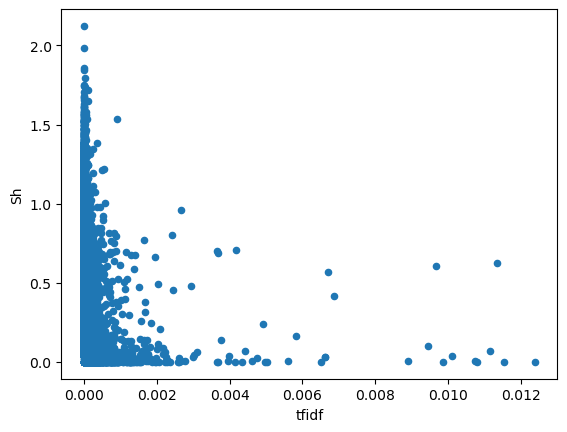

In [47]:
posdata.plot.scatter('tfidf','Sh')

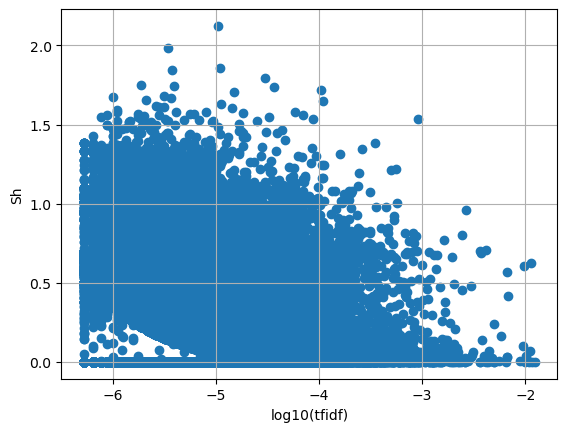

In [48]:
plt.scatter(np.log10(posdata['tfidf']),posdata['Sh'])
plt.xlabel('log10(tfidf)')
plt.ylabel('Sh')
plt.grid()

In [49]:
dfval.corr()

,value,ntoks,%na,mean,weight,prob,min_prob
value,1.000000,0.710412,-0.109981,0.611792,0.674325,-0.362952,-0.293347
ntoks,0.710412,1.000000,0.001934,-0.001510,0.071907,-0.465779,-0.372477
%na,-0.109981,0.001934,1.000000,-0.148539,-0.150015,0.194838,0.136990
mean,0.611792,-0.001510,-0.148539,1.000000,0.996662,-0.040408,-0.031257
weight,0.674325,0.071907,-0.150015,0.996662,1.000000,-0.075180,-0.059453
prob,-0.362952,-0.465779,0.194838,-0.040408,-0.075180,1.000000,0.922611
min_prob,-0.293347,-0.372477,0.136990,-0.031257,-0.059453,0.922611,1.000000


In [50]:
dfval.describe()

,value,ntoks,%na,mean,weight,prob,min_prob
count,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06,2.138181e+06
mean,8.668317e-03,2.546123e+01,2.224973e-01,3.406071e-04,1.108504e-01,2.721561e-01,4.124990e-01
std,6.424979e-03,1.353517e+01,1.083949e-01,1.937244e-04,6.225587e-02,2.975736e-01,3.039705e-01
min,4.942069e-05,4.000000e+00,0.000000e+00,1.184321e-05,3.700874e-03,1.012257e-22,0.000000e+00
25%,3.946951e-03,1.600000e+01,1.346154e-01,2.008695e-04,6.525061e-02,1.820336e-02,1.467903e-01
50%,7.172587e-03,2.300000e+01,2.105263e-01,3.050567e-04,9.994724e-02,1.475030e-01,3.193428e-01
75%,1.180798e-02,3.200000e+01,3.000000e-01,4.430101e-04,1.454267e-01,4.727337e-01,6.806512e-01
max,9.432141e-02,1.200000e+02,4.956522e-01,2.893250e-03,8.795480e-01,1.000000e+00,1.000000e+00


<AxesSubplot:xlabel='weight', ylabel='prob'>

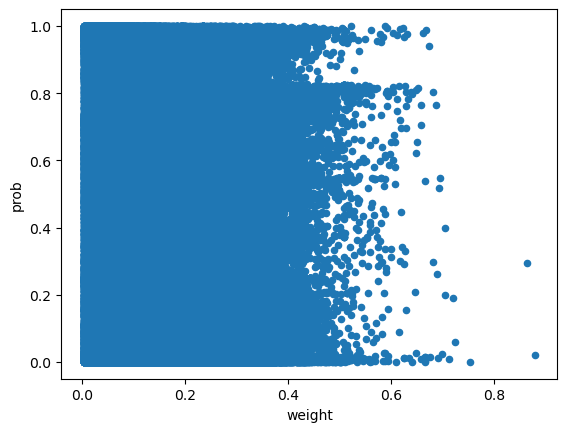

In [51]:
dfval.plot.scatter('weight','prob')

In [52]:
dfval.sort_values('min_prob').head(15)

,value,ntoks,%na,mean,weight,prob,min_prob
1287017,0.000631,4,0.250000,0.000158,0.047919,1.000000e+00,0.000000e+00
1478920,0.001485,4,0.250000,0.000371,0.112889,1.000000e+00,0.000000e+00
1703195,0.001660,10,0.100000,0.000166,0.051472,2.517146e-07,2.810231e-07
1585030,0.001770,19,0.157895,0.000093,0.029723,7.589973e-09,3.574687e-07
1995989,0.015279,42,0.261905,0.000364,0.124414,5.915472e-10,5.620463e-07
267910,0.002541,33,0.151515,0.000077,0.025640,7.426445e-11,5.620463e-07
353761,0.021476,62,0.338710,0.000346,0.125392,2.762329e-10,5.620463e-07
1180090,0.005421,31,0.290323,0.000175,0.057877,8.825566e-09,5.620463e-07
309813,0.022229,34,0.147059,0.000654,0.218368,3.396644e-09,7.149373e-07
1678251,0.010844,16,0.250000,0.000678,0.214165,4.322154e-07,7.149373e-07


In [73]:
for i in dfval[dfval.min_prob<0.9e-6].index:
    
    print(all_sents[i])
    print()

Se a é un enteiro, entón ['a', 'a'] = 'a'

Reconfortado por Agnese, comeza a relaxarse e está conforme en que el está profundamente namorado e, cando lle preguntan por unha carta, móstralle a ela a que el porta.

No entanto, as familias ricas de rentistas son substituídas por empresarios de xenio dados a fins do século XIX (Siemens, Edison, Ford e máis recentemente Bill Gates), como a foi no seu tempo a nobreza.

Da primeira, considerada a máis antiga, conservábanse as fundacións onde nunha pedra das mesmas se podía ler a seguinte inscrición en castelán: Este puente se hizo con vino de Cantalarrama.

A loita entre Afonso Henriques e a súa nai culmina o 24 de xullo de 1128 na batalla de San Mamede (Guimarães), tras a que Tareixa, derrotada, é explusada da terra que dirixira durante 15 anos; Afonso tomou a plena posesión do condado, e declarouno, despois da batalla de Ourique, reino idependente.

Anteriormente comercializábase co nome Zume de Laranxa El As, pero os seus donos, a familia 

#### Filter values

In [70]:
indx=list(dfval[dfval.min_prob<0.2e-6].index)
indx.sort(reverse=True)

In [72]:
for i in indx:
    all_toks.pop(i)
    all_sents.pop(i)